# Transfer learning - Survival prediction
Here we are initializing the survival prediction task by using the pre-trained weights from the "foundation model" and fine tuning on survival prediction. We use for training 70% of the data and 30% for validation. 

This notebook guides you through the use of the clinical transformere API

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/shenwanxiang/anaconda3"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
tf.test.is_gpu_available()

tf.config.run_functions_eagerly(True)

tf.__version__
import sys
sys.path.append('../../../codeocean/environment/clinical_transformer/')

2025-08-14 20:45:26.034710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 20:45:26.098169: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 20:45:26.462014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenwanxiang/anaconda3/lib:
2025-08-14 20:45:26.462057: W tensorflow/compiler/xla/stream_exe

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-08-14 20:45:26.883685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 20:45:26.913440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:45:26.929943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:45:26.930048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [2]:
from xai.models import Trainer
from xai.models import SurvivalTransformer
from xai.models import OptimizedSurvivalDataGenerator as SurvivalDataGenerator
from xai.losses.survival import cIndex_SigmoidApprox as cindex_loss
from xai.metrics.survival import sigmoid_concordance as cindex_metric

In [3]:
import pandas as pd
from samecode.random import set_seed

## Dataset

In [4]:
data = pd.read_csv('./data/dataset-train.data.csv')
features = data.columns[-29:].tolist()
#features

## Parameters

In [5]:
max_features_percentile=100
test_size=0.1 # fraction of samples used for validation
repetitions=10 # number replicates (training / validation) random splits to evaluate variability.

mode='survival'
learning_rate=0.0001
epochs=300
verbose=1
seed=0
embedding_size = 128
num_heads = 2
num_layers = 8

In [6]:
! rm -r ./results/TransferLearningSurvival/

/bin/sh: /home/shenwanxiang/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/sh)


## Training

In [7]:
outdir = './results/TransferLearningSurvival/'

set_seed(0)

trainer = Trainer(
    from_pretrained='../FoundationModel/fold-0_id-0/model.E002000.h5',
    out_dir = outdir,
    max_features_percentile=max_features_percentile,
    test_size=test_size,
    mode=mode,
    model=SurvivalTransformer, 
    dataloader=SurvivalDataGenerator,
    loss=cindex_loss,
    metrics=[cindex_metric]
)

trainer.setup_data(
    data, 
    discrete_features = [],
    continuous_features = features,
    target=['time', 'event']
)

trainer.setup_model(
    learning_rate=learning_rate,
    embedding_size=embedding_size,
    num_heads=num_heads,
    num_layers=num_layers,
    batch_size_max=True,
    save_best_only=False
)

trainer.fit(repetitions=repetitions, epochs=epochs, verbose=verbose, seed=seed)

/home/shenwanxiang/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO	2025-08-14 20:45:29,883	Setting up working directory: ./results/TransferLearningSurvival/
INFO	2025-08-14 20:45:29,884	Setting up transfer learning directory: ./results/TransferLearningSurvival//model.E002000.h5/
2025-08-14 20:45:29.886914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:45:29.887070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-14 20:45:29.887129: I tensorflow/compiler/xla/str

Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-08-14 20:45:30.984261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
WARNING	2025-08-14 20:45:31,171	AutoGraph could not transform <function cIndex_SigmoidApprox at 0x7f35b4118b00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-14 20:45:31,428	AutoGraph could not transform <function sigmoid_concordance at 0x7f355d0f7e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 998ms/step - loss: 0.5107 - sigmoid_concordance: 0.4834 - val_loss: 0.4975 - val_sigmoid_concordance: 0.5227
Epoch 2/300
1/1 [==============================] - 0s 351ms/step - loss: 0.5004 - sigmoid_concordance: 0.4965 - val_loss: 0.4749 - val_sigmoid_concordance: 0.5809
Epoch 3/300
1/1 [==============================] - 0s 348ms/step - loss: 0.4567 - sigmoid_concordance: 0.5859 - val_loss: 0.4571 - val_sigmoid_concordance: 0.6016
Epoch 4/300
1/1 [==============================] - 0s 338ms/step - loss: 0.4573 - sigmoid_concordance: 0.5766 - val_loss: 0.4429 - val_sigmoid_concordance: 0.6114
Epoch 5/300
1/1 [==============================] - 0s 337

INFO	2025-08-14 20:47:16,295	RUN ID: fold-1_id-1
INFO	2025-08-14 20:47:16,296	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-1_id-1/
INFO	2025-08-14 20:47:16,336	Training samples: 505
INFO	2025-08-14 20:47:16,336	Testing samples: 57
INFO	2025-08-14 20:47:16,337	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 511ms/step - loss: 0.4791 - sigmoid_concordance: 0.5377 - val_loss: 0.4652 - val_sigmoid_concordance: 0.5770
Epoch 2/300
1/1 [==============================] - 0s 344ms/step - loss: 0.4630 - sigmoid_concordance: 0.5642 - val_loss: 0.4508 - val_sigmoid_concordance: 0.5796
Epoch 3/300
1/1 [==============================] - 0s 352ms/step - loss: 0.4346 - sigmoid_concordance: 0.6035 - val_loss: 0.4369 - val_sigmoid_concordance: 0.5813
Epoch 4/300
1/1 [==============================] - 0s 329ms/step - loss: 0.4217 - sigmoid_concordance: 0.6115 - val_loss: 0.4255 - val_sigmoid_concordance: 0.5872
Epoch 5/300
1/1 [==============================] - 0s 338ms/step - loss: 0.4126 - sigmoid_concordance: 0.6115 - val_loss: 0.4187 - val_sigmoid_concordance: 0.5864
Epoch 6/300
1/1 [==============================] - 0s 343ms/step - loss: 0.3961 - sigmoid_concordance: 0.6260 - val_loss: 0.4152 - val_sigmoid_concordance: 0.5855
Epoch 7/300
1/1 [=====

INFO	2025-08-14 20:49:01,868	RUN ID: fold-2_id-2
INFO	2025-08-14 20:49:01,868	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-2_id-2/
INFO	2025-08-14 20:49:01,909	Training samples: 505
INFO	2025-08-14 20:49:01,909	Testing samples: 57
INFO	2025-08-14 20:49:01,910	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 509ms/step - loss: 0.5166 - sigmoid_concordance: 0.4638 - val_loss: 0.4908 - val_sigmoid_concordance: 0.5227
Epoch 2/300
1/1 [==============================] - 0s 352ms/step - loss: 0.4708 - sigmoid_concordance: 0.5570 - val_loss: 0.4851 - val_sigmoid_concordance: 0.5177
Epoch 3/300
1/1 [==============================] - 0s 344ms/step - loss: 0.4481 - sigmoid_concordance: 0.5912 - val_loss: 0.4826 - val_sigmoid_concordance: 0.5136
Epoch 4/300
1/1 [==============================] - 0s 363ms/step - loss: 0.4351 - sigmoid_concordance: 0.6022 - val_loss: 0.4826 - val_sigmoid_concordance: 0.5111
Epoch 5/300
1/1 [==============================] - 0s 346ms/step - loss: 0.4083 - sigmoid_concordance: 0.6265 - val_loss: 0.4817 - val_sigmoid_concordance: 0.5177
Epoch 6/300
1/1 [==============================] - 0s 355ms/step - loss: 0.3981 - sigmoid_concordance: 0.6276 - val_loss: 0.4807 - val_sigmoid_concordance: 0.5144
Epoch 7/300
1/1 [=====

INFO	2025-08-14 20:50:47,550	RUN ID: fold-3_id-3
INFO	2025-08-14 20:50:47,550	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-3_id-3/
INFO	2025-08-14 20:50:47,600	Training samples: 505
INFO	2025-08-14 20:50:47,600	Testing samples: 57
INFO	2025-08-14 20:50:47,601	Number of features at 100th percentile: 29 that are non nans


Epoch 1/300


/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1/1 [==============================] - 1s 510ms/step - loss: 0.4754 - sigmoid_concordance: 0.5544 - val_loss: 0.4194 - val_sigmoid_concordance: 0.6563
Epoch 2/300
1/1 [==============================] - 0s 359ms/step - loss: 0.4605 - sigmoid_concordance: 0.5677 - val_loss: 0.3866 - val_sigmoid_concordance: 0.6799
Epoch 3/300
1/1 [==============================] - 0s 347ms/step - loss: 0.4616 - sigmoid_concordance: 0.5551 - val_loss: 0.3613 - val_sigmoid_concordance: 0.6942
Epoch 4/300
1/1 [==============================] - 0s 347ms/step - loss: 0.4221 - sigmoid_concordance: 0.6093 - val_loss: 0.3431 - val_sigmoid_concordance: 0.6967
Epoch 5/300
1/1 [==============================] - 0s 342ms/step - loss: 0.4177 - sigmoid_concordance: 0.6039 - val_loss: 0.3306 - val_sigmoid_concordance: 0.7094
Epoch 6/300
1/1 [==============================] - 0s 337ms/step - loss: 0.4024 - sigmoid_concordance: 0.6172 - val_loss: 0.3219 - val_sigmoid_concordance: 0.7152
Epoch 7/300
1/1 [=================

INFO	2025-08-14 20:52:33,427	RUN ID: fold-4_id-4
INFO	2025-08-14 20:52:33,427	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-4_id-4/
INFO	2025-08-14 20:52:33,468	Training samples: 505
INFO	2025-08-14 20:52:33,469	Testing samples: 57
INFO	2025-08-14 20:52:33,470	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 521ms/step - loss: 0.4935 - sigmoid_concordance: 0.5118 - val_loss: 0.4960 - val_sigmoid_concordance: 0.5172
Epoch 2/300
1/1 [==============================] - 0s 342ms/step - loss: 0.4940 - sigmoid_concordance: 0.5082 - val_loss: 0.4715 - val_sigmoid_concordance: 0.5915
Epoch 3/300
1/1 [==============================] - 0s 342ms/step - loss: 0.4640 - sigmoid_concordance: 0.5680 - val_loss: 0.4488 - val_sigmoid_concordance: 0.6145
Epoch 4/300
1/1 [==============================] - 0s 351ms/step - loss: 0.4557 - sigmoid_concordance: 0.5762 - val_loss: 0.4301 - val_sigmoid_concordance: 0.6233
Epoch 5/300
1/1 [==============================] - 0s 352ms/step - loss: 0.4319 - sigmoid_concordance: 0.6085 - val_loss: 0.4170 - val_sigmoid_concordance: 0.6145
Epoch 6/300
1/1 [==============================] - 0s 350ms/step - loss: 0.4254 - sigmoid_concordance: 0.6057 - val_loss: 0.4086 - val_sigmoid_concordance: 0.6172
Epoch 7/300
1/1 [=====

INFO	2025-08-14 20:54:18,966	RUN ID: fold-5_id-5
INFO	2025-08-14 20:54:18,967	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-5_id-5/
INFO	2025-08-14 20:54:19,008	Training samples: 505
INFO	2025-08-14 20:54:19,008	Testing samples: 57
INFO	2025-08-14 20:54:19,009	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 570ms/step - loss: 0.4991 - sigmoid_concordance: 0.5046 - val_loss: 0.4700 - val_sigmoid_concordance: 0.5679
Epoch 2/300
1/1 [==============================] - 0s 365ms/step - loss: 0.4578 - sigmoid_concordance: 0.5826 - val_loss: 0.4571 - val_sigmoid_concordance: 0.5743
Epoch 3/300
1/1 [==============================] - 0s 356ms/step - loss: 0.4466 - sigmoid_concordance: 0.5904 - val_loss: 0.4479 - val_sigmoid_concordance: 0.5716
Epoch 4/300
1/1 [==============================] - 0s 350ms/step - loss: 0.4179 - sigmoid_concordance: 0.6187 - val_loss: 0.4445 - val_sigmoid_concordance: 0.5725
Epoch 5/300
1/1 [==============================] - 0s 345ms/step - loss: 0.4233 - sigmoid_concordance: 0.6020 - val_loss: 0.4437 - val_sigmoid_concordance: 0.5706
Epoch 6/300
1/1 [==============================] - 0s 343ms/step - loss: 0.3919 - sigmoid_concordance: 0.6372 - val_loss: 0.4441 - val_sigmoid_concordance: 0.5679
Epoch 7/300
1/1 [=====

INFO	2025-08-14 20:56:04,940	RUN ID: fold-6_id-6
INFO	2025-08-14 20:56:04,941	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-6_id-6/
INFO	2025-08-14 20:56:04,982	Training samples: 505
INFO	2025-08-14 20:56:04,983	Testing samples: 57
INFO	2025-08-14 20:56:04,984	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 503ms/step - loss: 0.4723 - sigmoid_concordance: 0.5514 - val_loss: 0.4483 - val_sigmoid_concordance: 0.5984
Epoch 2/300
1/1 [==============================] - 0s 336ms/step - loss: 0.4584 - sigmoid_concordance: 0.5714 - val_loss: 0.4184 - val_sigmoid_concordance: 0.6215
Epoch 3/300
1/1 [==============================] - 0s 334ms/step - loss: 0.4328 - sigmoid_concordance: 0.5991 - val_loss: 0.3992 - val_sigmoid_concordance: 0.6259
Epoch 4/300
1/1 [==============================] - 0s 331ms/step - loss: 0.4229 - sigmoid_concordance: 0.6029 - val_loss: 0.3894 - val_sigmoid_concordance: 0.6277
Epoch 5/300
1/1 [==============================] - 0s 346ms/step - loss: 0.4140 - sigmoid_concordance: 0.6037 - val_loss: 0.3840 - val_sigmoid_concordance: 0.6348
Epoch 6/300
1/1 [==============================] - 0s 335ms/step - loss: 0.3889 - sigmoid_concordance: 0.6327 - val_loss: 0.3799 - val_sigmoid_concordance: 0.6436
Epoch 7/300
1/1 [=====

INFO	2025-08-14 20:57:50,653	RUN ID: fold-7_id-7
INFO	2025-08-14 20:57:50,653	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-7_id-7/
INFO	2025-08-14 20:57:50,694	Training samples: 505
INFO	2025-08-14 20:57:50,694	Testing samples: 57
INFO	2025-08-14 20:57:50,695	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 502ms/step - loss: 0.4746 - sigmoid_concordance: 0.5479 - val_loss: 0.4806 - val_sigmoid_concordance: 0.5313
Epoch 2/300
1/1 [==============================] - 0s 340ms/step - loss: 0.4395 - sigmoid_concordance: 0.5978 - val_loss: 0.4742 - val_sigmoid_concordance: 0.5341
Epoch 3/300
1/1 [==============================] - 0s 347ms/step - loss: 0.4134 - sigmoid_concordance: 0.6244 - val_loss: 0.4722 - val_sigmoid_concordance: 0.5425
Epoch 4/300
1/1 [==============================] - 0s 342ms/step - loss: 0.4028 - sigmoid_concordance: 0.6262 - val_loss: 0.4723 - val_sigmoid_concordance: 0.5415
Epoch 5/300
1/1 [==============================] - 0s 342ms/step - loss: 0.3868 - sigmoid_concordance: 0.6369 - val_loss: 0.4716 - val_sigmoid_concordance: 0.5472
Epoch 6/300
1/1 [==============================] - 0s 346ms/step - loss: 0.3794 - sigmoid_concordance: 0.6395 - val_loss: 0.4705 - val_sigmoid_concordance: 0.5472
Epoch 7/300
1/1 [=====

INFO	2025-08-14 20:59:38,277	RUN ID: fold-8_id-8
INFO	2025-08-14 20:59:38,277	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-8_id-8/
INFO	2025-08-14 20:59:38,318	Training samples: 505
INFO	2025-08-14 20:59:38,318	Testing samples: 57
INFO	2025-08-14 20:59:38,319	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 508ms/step - loss: 0.5177 - sigmoid_concordance: 0.4640 - val_loss: 0.4717 - val_sigmoid_concordance: 0.6290
Epoch 2/300
1/1 [==============================] - 0s 361ms/step - loss: 0.4887 - sigmoid_concordance: 0.5273 - val_loss: 0.4423 - val_sigmoid_concordance: 0.6543
Epoch 3/300
1/1 [==============================] - 0s 350ms/step - loss: 0.4676 - sigmoid_concordance: 0.5662 - val_loss: 0.4145 - val_sigmoid_concordance: 0.6480
Epoch 4/300
1/1 [==============================] - 0s 344ms/step - loss: 0.4569 - sigmoid_concordance: 0.5724 - val_loss: 0.3903 - val_sigmoid_concordance: 0.6498
Epoch 5/300
1/1 [==============================] - 0s 345ms/step - loss: 0.4145 - sigmoid_concordance: 0.6254 - val_loss: 0.3746 - val_sigmoid_concordance: 0.6561
Epoch 6/300
1/1 [==============================] - 0s 349ms/step - loss: 0.4254 - sigmoid_concordance: 0.5993 - val_loss: 0.3666 - val_sigmoid_concordance: 0.6588
Epoch 7/300
1/1 [=====

INFO	2025-08-14 21:01:24,688	RUN ID: fold-9_id-9
INFO	2025-08-14 21:01:24,689	RUN ID out directory: ./results/TransferLearningSurvival//model.E002000.h5//fold-9_id-9/
INFO	2025-08-14 21:01:24,729	Training samples: 505
INFO	2025-08-14 21:01:24,730	Testing samples: 57
INFO	2025-08-14 21:01:24,731	Number of features at 100th percentile: 29 that are non nans
/home/shenwanxiang/anaconda3/envs/IRnet_env/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1/1 [==============================] - 1s 506ms/step - loss: 0.5198 - sigmoid_concordance: 0.4548 - val_loss: 0.4841 - val_sigmoid_concordance: 0.5699
Epoch 2/300
1/1 [==============================] - 0s 344ms/step - loss: 0.4863 - sigmoid_concordance: 0.5294 - val_loss: 0.4664 - val_sigmoid_concordance: 0.6237
Epoch 3/300
1/1 [==============================] - 0s 343ms/step - loss: 0.4563 - sigmoid_concordance: 0.5834 - val_loss: 0.4532 - val_sigmoid_concordance: 0.5977
Epoch 4/300
1/1 [==============================] - 0s 349ms/step - loss: 0.4493 - sigmoid_concordance: 0.5943 - val_loss: 0.4421 - val_sigmoid_concordance: 0.5887
Epoch 5/300
1/1 [==============================] - 0s 343ms/step - loss: 0.4372 - sigmoid_concordance: 0.5985 - val_loss: 0.4339 - val_sigmoid_concordance: 0.5878
Epoch 6/300
1/1 [==============================] - 0s 347ms/step - loss: 0.4130 - sigmoid_concordance: 0.6216 - val_loss: 0.4285 - val_sigmoid_concordance: 0.5887
Epoch 7/300
1/1 [=====

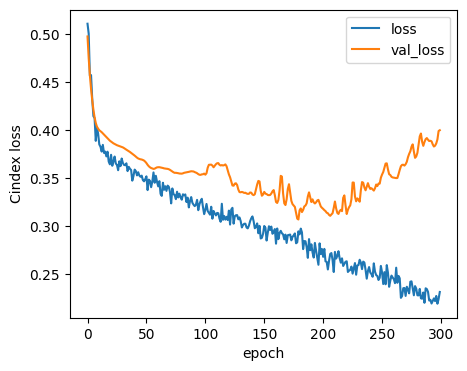

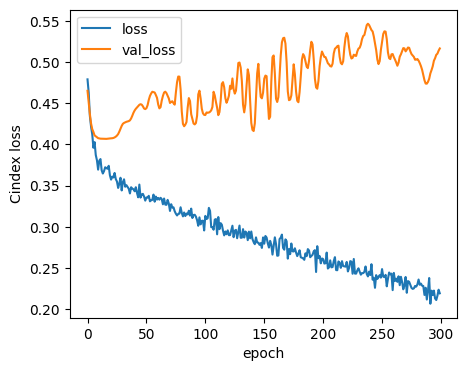

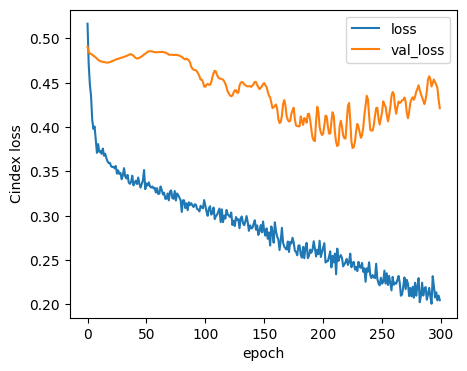

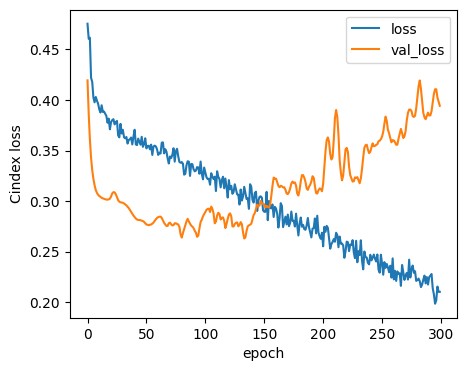

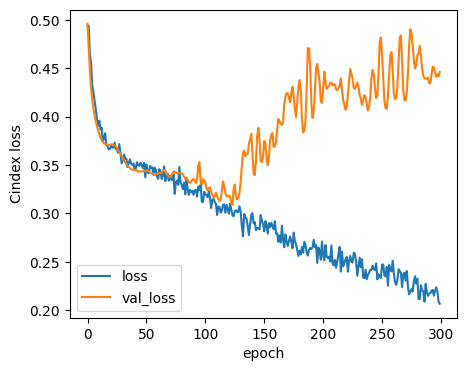

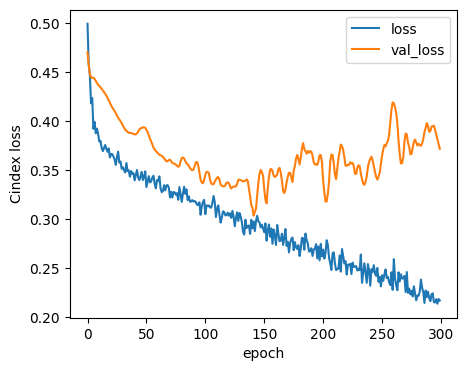

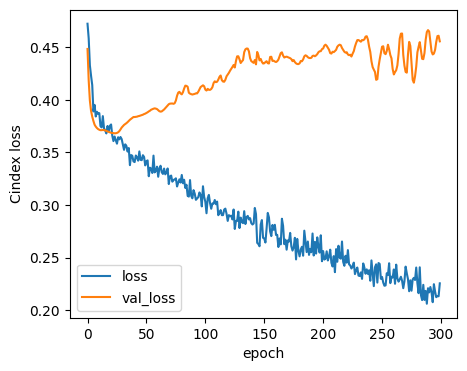

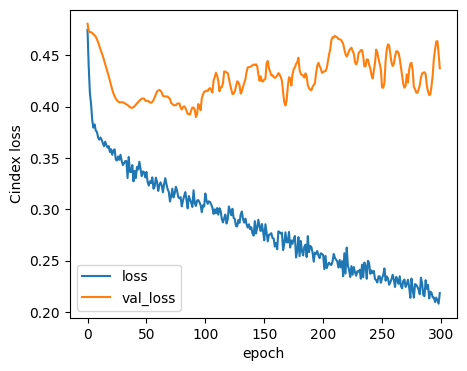

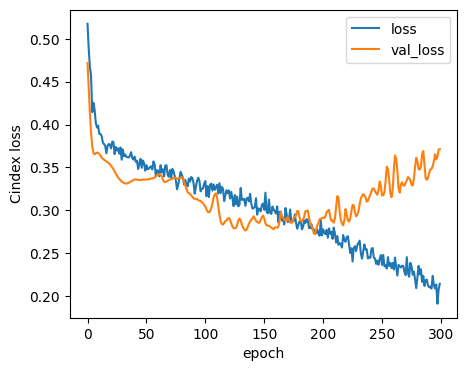

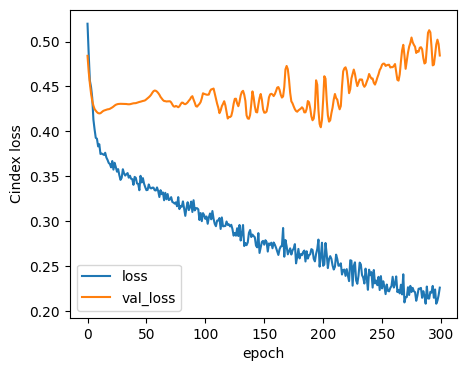

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
best_es = []
for i in range(repetitions):
    dfh = pd.read_csv("./results/TransferLearningSurvival/model.E002000.h5/fold-%s_id-%s/history.csv" % (i,i), index_col=0)
    fig, ax=plt.subplots(figsize=(5,4))
    dfh[['loss', 'val_loss']].plot(ax=ax)
    ax.set_ylabel('Cindex loss')
    
    best_e1 = dfh.val_loss.idxmin()
    best_e2 = dfh.val_sigmoid_concordance.idxmax()
    best_es.append(best_e1)
    #best_es.append(best_e2)
    
best_epoch = pd.DataFrame(best_es)[0].median()

In [9]:
pd.DataFrame(best_es).median()

0    137.0
dtype: float64